In [1]:
%matplotlib inline

import os, sys
sys.path.append(os.path.split(sys.path[0])[0])

from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from utils.plotting.plot_results import plot_LFP_traces,plot_LFP_heatmap
from stylized_module.feature_extraction.SummaryStats2D import Stats, Grid_LFP
# from stylized_module.base.active_model_synapse_input import *
from stylized_module.base.passive_model_soma_injection import *
import config.params as params
import config.paths as paths

tstop = 20.  # ms
dt = 0.025  # ms. does not allow change

# h.nrn_load_dll(os.path.join(mechanisms_path,'nrnmech.dll'))  # running this line more than once might crash the kernel
# h.nrn_load_dll(os.path.join(mechanisms_path,'x86_64/.libs/libnrnmech.so'))  # use this line instead in Linux
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = tstop
h.dt = dt

In [2]:
rng = np.random.default_rng(12345)
#            x, y, z,  alpha, h,   phi
loc_param = [0, 0, 50, 0,     1.0, 0.0]
#           [r_s, l_t, r_t, r_d, r_tu, l_d] -> [6.0, 400.0, 0.5, 0.5, 0.5, 200.0]
geo_param = [6.0,400.0,0.5,0.5,0.5,200.0]
loc_param_list = []
geo_param_list = []
labels = []
ncell=1000
for i in range(ncell):
    offset = rng.uniform(low=20., high=800.)
    if i%1000 == 0:
        print(offset)
    loc_param_list.append(loc_param)
    labels.append(offset)
#     geo_param_list.append(geo_param)
    geo_param_list.append([geo_param[0]] + [offset] + geo_param[2:])
    
# geo_param = [-1,-1,-1]  # choose trunk length [-1,600], bounds([3,12],[20,800],[0.2,1.0],[0.2,1.0],[0.2,1.0],[100,300])
# biophys = [-1,-1,-1,-1,-1]
loc_param = np.stack(loc_param_list)
geo_param = np.stack(geo_param_list)
labels = np.stack(labels)
np.set_printoptions(suppress=True)
print(loc_param.shape)
print(geo_param.shape)
print(labels.shape)

197.32209752439235
(1000, 6)
(1000, 6)
(1000,)


In [3]:
hf = h5py.File(paths.INVIVO_DATA_FILE, 'r')
groundtruth_lfp = np.array(hf.get('data'))
hf.close()

maxIndx = np.argmax(np.absolute(groundtruth_lfp).max(axis=0))  # find maximum absolute value from averaged traces
maxTrace = -groundtruth_lfp[params.PM_START_IDX:,maxIndx]
soma_injection = np.insert(maxTrace,0,0.)
soma_injection = np.asarray([s * params.PM_SCALING_FACTOR for s in soma_injection])

# sim = Simulation(geo_standard,params.ELECTRODE_POSITION,loc_param,geo_param=geo_param,gmax=.001,scale=1000, ncell=ncell)  # gmax 0.001 -0.012
sim = Simulation(geo_standard,params.ELECTRODE_POSITION,soma_injection,loc_param=loc_param,geo_param=geo_param, ncell=ncell) 
sec_list = sim.cells[0].all
dend_v = Recorder([sec_list[5](0.1),sec_list[5](0.5),sec_list[5](0.9),sec_list[6](0.5)])

In [4]:
lfp_list = []
sim.run()
for i in range(ncell):
    lfp_list.append(sim.get_lfp(i).T)
    lfp_list[-1] /= np.max(np.abs(lfp_list[-1]))
    
t = sim.t()
print(len(t))
print(np.stack(lfp_list, axis=-1).shape)

801
(801, 384, 1000)


In [5]:
params.IM_Y_DISTANCE[240]

490.0

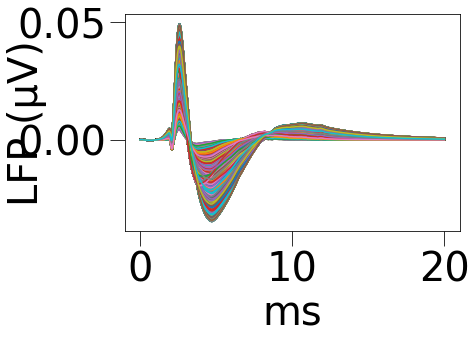

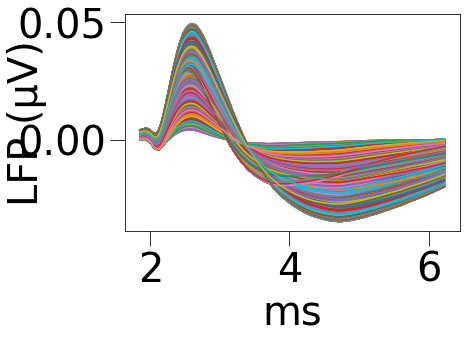

(37, 1000)


In [6]:
from utils.spike_window import first_pk_tr, get_spike_window

np.set_printoptions(precision=4)

lfp_plot = np.stack(lfp_list, axis=-1)[:,240,:]
# argmax_list = []
# for i in range(lfp_plot.shape[0]):
#     argmax_list.append(np.argmax(lfp_plot[i,:,1]))
# print(argmax_list)

delay = 9.0
window = [delay,delay+2.51]
idx = (t>=window[0]) & (t<=window[1])  # time index
# print(t.shape)
fig,ax = plot_LFP_traces(t,lfp_plot,savefig=paths.IMAGE_SAVE + '/LFP_z_traces.jpg')

fst_idx = first_pk_tr(lfp_plot)

start,end = get_spike_window(lfp_plot,win_size=params.PM_WINDOW_SIZE,align_at=30)

predicted_lfp_win = lfp_plot[start:end,:]

fig,ax = plot_LFP_traces(t[start:end],
                         predicted_lfp_win)
# predicted_lfp_win = ((lfp_list[0])[start:end,:])

elec_idx = slice(30,-10)
stats_list = []
for i in range(geo_param.shape[0]):
    g_lfp, grid = Grid_LFP(lfp_list[i],params.ELECTRODE_POSITION,params.ELECTRODE_GRID)
    stats = Stats(g_lfp, grid)
    testvar = loc_param[i,2]
    stats_list.append(stats)
#     fig,ax = plot_LFP_heatmap(t[start:end],
#                               params.IM_Y_DISTANCE[elec_idx],
#                               ((lfp_list[i])[start:end,:])[:,elec_idx],
#                               vlim='auto',
#                               savefig=paths.IMAGE_SAVE + "/z_" + str(testvar) + ".jpg")
    
stats_list = np.column_stack(stats_list)
print(stats_list.shape)
np.savetxt("foo.csv", stats_list, fmt='%.4f', delimiter=",")

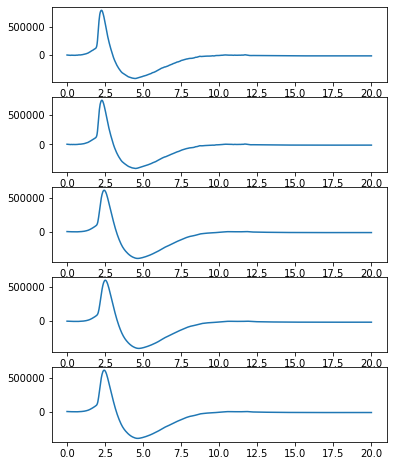

In [7]:
v_dend = dend_v.as_numpy()
plt.figure(figsize=(6,8))
plt.subplot(5,1,1)
plt.plot(t,sim.cells[0].v())
for i in range(v_dend.shape[0]):
    plt.subplot(5,1,i+2)
    plt.plot(t,v_dend[i,:])
plt.show()

In [34]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from numpy import genfromtxt
from tqdm.notebook import tqdm
import copy, time
from sklearn.metrics import r2_score

class FCN(nn.Module):
    def __init__(self, in_size, out_size):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(in_size, 150)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(150, 50)
        self.fc3 = nn.Linear(50, out_size)
        
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

In [35]:
stats_list = genfromtxt('foo.csv', delimiter=',')
stats_list = np.transpose(stats_list)
np.save("inputs.npy", stats_list)
np.save("labels.npy", labels)
batch=32
trainingDataset = TensorDataset(torch.Tensor(stats_list[:800,:]), torch.Tensor(labels[:800]))
testingDataset = TensorDataset(torch.Tensor(stats_list[800:,:]), torch.Tensor(labels[800:]))
train_loader = DataLoader(dataset=trainingDataset, batch_size=batch)
test_loader = DataLoader(dataset=testingDataset, batch_size=batch)

In [36]:
def train_model(model,training_loader,validation_loader,epochs,device):
    epochs_list = []
    train_loss_list = []
    val_loss_list = []
    training_len = len(training_loader.dataset)
    validation_len = len(validation_loader.dataset)
    
#     feedback_arr = torch.zeros(params.BATCH_SIZE, 90)
    
    #splitting the dataloaders to generalize code
    data_loaders = {"train": training_loader, "val": validation_loader}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    loss_func = nn.MSELoss()
    decay_rate = .99995 #0.98 #decay the lr each step to 98% of previous lr
    lr_sch = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

    total_start = time.time()

    """
    You can easily adjust the number of epochs trained here by changing the number in the range
    """
    for epoch in tqdm(range(epochs), position=0, leave=True):
        start = time.time()
        train_loss = 0.0
        val_loss = 0.0
        temp_loss = 100000000000000.0
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            for i, (x, y) in enumerate(data_loaders[phase]):
                x = x.to(device)
                output = model(x)
                y = y.to(device)
                loss = loss_func(torch.squeeze(output), torch.squeeze(y)) 
                #backprop             
                optimizer.zero_grad()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                #calculating total loss
                running_loss += loss.item()
            
            if phase == 'train':
                train_loss = running_loss
                lr_sch.step()
            else:
                val_loss = running_loss

        end = time.time()
        # shows total loss
        if epoch%5 == 0:
            print('[%d, %5d] train loss: %.6f val loss: %.6f' % (epoch + 1, i + 1, train_loss, val_loss))
#         print(end - start)
        
        #saving best model
        if train_loss < temp_loss:
            torch.save(model, "temp_model.pt")
            temp_loss = train_loss
        epochs_list.append(epoch)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
    total_end = time.time()
    # Writing loss csv, change path to whatever you want to name it
    return train_loss_list, val_loss_list


In [37]:
model1 = FCN(37, 1)
model_initial = copy.deepcopy(model1)
# model1 = torch.load("temp_model.pt")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model1.to(device)


pnfr_training_loss, pnfr_validation_loss = train_model(model1,train_loader,
                                                       test_loader,50,device)

  0%|          | 0/50 [00:00<?, ?it/s]

[1,     7] train loss: 4498794.796875 val loss: 1062376.640625
[6,     7] train loss: 961314.587891 val loss: 251361.912109
[11,     7] train loss: 775481.675781 val loss: 197611.804688
[16,     7] train loss: 518995.875977 val loss: 129824.469727
[21,     7] train loss: 315917.787109 val loss: 78161.014648
[26,     7] train loss: 208521.629395 val loss: 51456.275391
[31,     7] train loss: 143455.652100 val loss: 35309.522949
[36,     7] train loss: 92899.221924 val loss: 22968.074463
[41,     7] train loss: 63248.351074 val loss: 15982.598877
[46,     7] train loss: 47094.548706 val loss: 12296.013306


In [39]:
x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu")
y = y.to("cpu")
print("R2: {}".format(r2_score(y.cpu().detach().numpy(), output.cpu().detach().numpy())))
print(output)
print(y)

R2: 0.9779440510590512
tensor([[795.0074],
        [712.2307],
        [468.9655],
        [314.6605],
        [ 76.6800],
        [ 34.1732],
        [254.3270],
        [542.7126],
        [260.0977],
        [260.0617],
        [427.2480],
        [590.1005],
        [809.4270],
        [795.9905],
        [445.0247],
        [476.6826],
        [312.5561],
        [143.1006],
        [469.1012],
        [142.7713],
        [711.9866],
        [143.0190],
        [519.9609],
        [ 13.0841],
        [527.3347],
        [254.6147],
        [476.5404],
        [661.0566],
        [-32.6117],
        [314.3306],
        [113.7198],
        [268.9010]], grad_fn=<AddmmBackward>)
tensor([765.0929, 717.6356, 518.3589, 291.9962,  97.9768,  71.6940, 233.4943,
        593.2185, 221.5318, 221.3658, 431.4977, 619.9763, 785.5964, 769.0469,
        464.5469, 523.8017, 280.1986, 136.2501, 510.7196, 139.8225, 714.2765,
        135.1053, 541.0101,  62.0953, 556.0448, 174.0505, 531.0403, 675.0137,